In [111]:
import os
import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

# Weekly Reanalysis Data 

Using the surface temperature data from the ERA-5 European Reanalysis, we can to calculate the surface temperatures means for the northern hemishpere for a dummy winter (Dec 2007 to Mar 2008). 


In [3]:
era_5_sfc_temp = iris.load('../cdsapi_requested_files/adaptor.mars.external-1579561890.771786-7623-33-477f8046-dadc-4922-9f24-ef068afe5647.grib')
era_5_sfc_temp_array = xr.DataArray.from_iris(era_5_sfc_temp[0])

Alternatively, we can use the grib ECM drivers to read GRIB files directly. But reading with `iris` activates the `dask.array` which makes operations faster.

```
ds_grib = xr.load_dataset('../cdsapi_requested_files/adaptor.mars.external-1579561890.771786-7623-33-477f8046-dadc-4922-9f24-ef068afe5647.grib', 
                          engine='cfgrib')
ds_grib
```

Resample data to the week level (weekly means):

In [120]:
era_5_sfc_temp_array_week = era_5_sfc_temp_array.resample(time='1W').reduce(np.mean)
era_5_sfc_temp_array_week

<xarray.DataArray 'air_temperature' (time: 14, dim_1: 542080)>
dask.array<stack, shape=(14, 542080), dtype=float64, chunksize=(1, 542080), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 2007-12-02 ... 2008-03-02
    forecast_period     timedelta64[ns] 00:00:00
    height              int64 2
    originating_centre  <U50 'European Centre for Medium Range Weather Forecasts'
    latitude            (dim_1) float64 89.78 89.78 89.78 ... -89.78 -89.78
    longitude           (dim_1) float64 0.0 20.0 40.0 60.0 ... 300.0 320.0 340.0
Dimensions without coordinates: dim_1

Transform data to `pandas` and calculate number of grids per temperature bucket (5-degrees)

In [125]:
era_5_sfc_temp_df =  era_5_sfc_temp_array_week.to_dataframe().\
reset_index(drop=False).\
filter(['latitude', 'longitude', 'time', 'air_temperature'])

In [123]:
era_5_sfc_temp_df =  era_5_sfc_temp_array_week.to_dataframe()

In [128]:
cut_off = list(range(int(min(era_5_sfc_temp_df.air_temperature)), 
           int(max(era_5_sfc_temp_df.air_temperature)),
           5))

era_5_sfc_temp = era_5_sfc_temp_df.assign(temp_bracket =  pd.cut(era_5_sfc_temp_df['air_temperature'], cut_off))

Distribution of temperature by number of grids

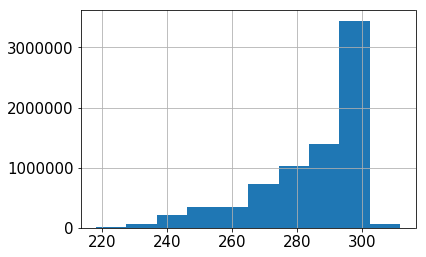

In [129]:
era_5_sfc_temp.air_temperature.hist()

In [137]:
era_5_sfc_group = era_5_sfc_temp.groupby(['temp_bracket', 'time'], as_index=False)['latitude'].count()
era_5_sfc_group['left_temp_interval']  = era_5_sfc_group.temp_bracket.apply(lambda x: x.left)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0,0.5,'Number of Reanalysis grids'), Text(0.5,0,'Temp Bracket (K)')]

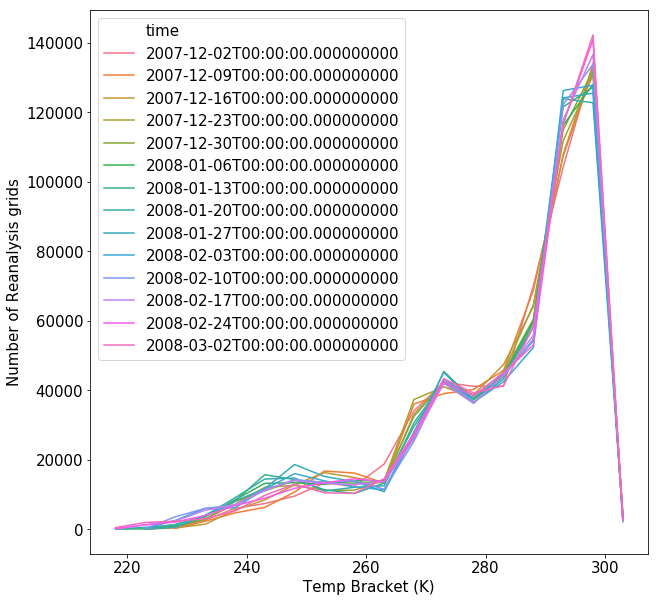

In [138]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="latitude", 
             hue='time', 
             data=era_5_sfc_group)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0,0.5,'Number of Reanalysis grids'), Text(0.5,0,'Temp Bracket (K)')]

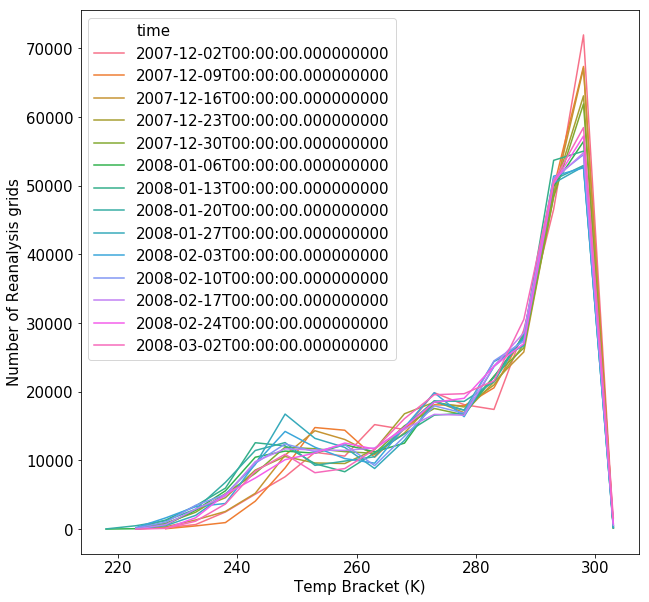

In [139]:
era_5_sfc_temp_high = era_5_sfc_temp[era_5_sfc_temp.latitude > 0]
era_5_sfc_group_high = era_5_sfc_temp_high.groupby(['temp_bracket', 'time'], as_index=False)['latitude'].count()
era_5_sfc_group_high['left_temp_interval']  = era_5_sfc_group_high.temp_bracket.apply(lambda x: x.left)

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="latitude", 
             hue='time', 
             data=era_5_sfc_group_high)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')